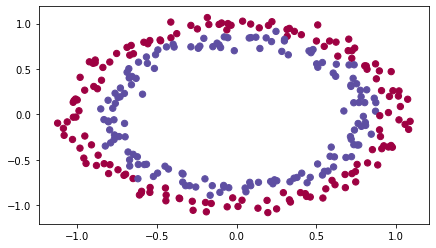

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
from init_utils_v2 import sigmoid, relu, sigmoid_backward, relu_backward
from init_utils_v2 import load_dataset

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = load_dataset()

## AIM

Build a classifier to separate the blue dots from the red dots

In [2]:
# no learning done, PLAIN WRONG

def initialize_parameters_zeros(layers_dims):
    parameters={}
    L = len(layers_dims)
    
    for l in range(1, L):
        W = 'W{}'.format(str(l))
        b = 'b{}'.format(str(l))
        
        parameters[W] = np.zeros((layers_dims[l], layers_dims[l-1]))
        parameters[b] = np.zeros((layers_dims[l], 1))
    
    return parameters

In [3]:
# CORRECT LOGIC BUT W PARAM INIT IS WAY TOO HIGH

def initialize_parameters_random(layers_dims):
    np.random.seed(3)  # to get same values as corrected example
    
    parameters={}
    L = len(layers_dims)
    
    for l in range(1, L):
        W = 'W{}'.format(str(l))
        b = 'b{}'.format(str(l))
        
        parameters[W] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 10
        parameters[b] = np.zeros((layers_dims[l], 1))
    
    return parameters

In [4]:
# RECOMMENDED INITIALIZATION TECHNIQUE

def initialize_parameters_he(layers_dims):
    'applied to RELU activation function'
    np.random.seed(3)
    
    parameters = {}
    L = len(layers_dims)
    
    for l in range(1, L):
        W = 'W{}'.format(str(l))
        b = 'b{}'.format(str(l))
        
        parameters[W] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        parameters[b] = np.zeros((layers_dims[l], 1))
        
    return parameters

## Implement forward Propagation

In [5]:
def linear_activation_forward(A_prev, W, b, activation):
    
    def linear_forward(A, W, b):
        Z = np.dot(W, A) + b
        cache = (A, W, b)
        return Z, cache
    
    if activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    
    caches = (linear_cache, activation_cache)
    
    return A, caches

In [6]:
def L_model_forward(X, parameters):
    A = X
    L = len(parameters) // 2
    caches = list()
    
    for l in range(1, L):
        A_prev = A
        
        A, cache = linear_activation_forward(A_prev,
                                             parameters.get('W{}'.format(str(l))),
                                             parameters.get('b{}'.format(str(l))),
                                             activation = 'relu')
        
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, 
                                          parameters.get('W{}'.format(str(L))),
                                          parameters.get('b{}'.format(str(L))),
                                          activation='sigmoid')
    caches.append(cache)
    
    return AL, caches

## Calculate Cost function

In [7]:
def compute_loss(AL, Y):
    m = Y.shape[1]
    
    logprobs = np.multiply(Y, np.log(AL)) + np.multiply((1-Y), (np.log(1-AL)))
    cost = (-1/m) * np.sum(logprobs)
    
    cost = np.squeeze(cost)
    return cost

## Implement Backward Propagation

In [8]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    def linear_backward(dZ, cache):
    # cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
        A_prev, W, b = cache
        m = A_prev.shape[1]
        dW = (1/m) * np.dot(dZ, A_prev.T)
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
        return dA_prev, dW, db
    
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [9]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # initialize dAL by taking derivative of loss function
    dAL = -(np.divide(Y,AL)-np.divide((1-Y), (1-AL)))
    
    current_cache = caches[-1]
    
    grads["dA{}".format(str(L))], grads["dW{}".format(str(L))], grads["db{}".format(str(L))] = linear_activation_backward(dAL,
                                                                                                                          current_cache,
                                                                                                                          'sigmoid')
    
    for l in reversed(range(L-1)):
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l + 2)], caches[l], 'relu')
        grads["dA{}".format(str(l+1))] = dA_prev
        grads["dW{}".format(str(l+1))] = dW
        grads["db{}".format(str(l+1))] = db
        
    return grads

In [10]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        W = "W{}".format(str(l+1))
        b = "b{}".format(str(l+1))
        dW = "dW{}".format(str(l+1))
        db = "db{}".format(str(l+1))
        
        parameters[W] = parameters.get(W) - learning_rate * grads[dW]
        parameters[b] = parameters.get(b) - learning_rate * grads[db]
    
    return parameters

## aggregate all as model

In [11]:
def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost = True, initialization = "he"):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (containing 0 for red dots; 1 for blue dots), of shape (1, number of examples)
    learning_rate -- learning rate for gradient descent 
    num_iterations -- number of iterations to run gradient descent
    print_cost -- if True, print the cost every 1000 iterations
    initialization -- flag to choose which initialization to use ("zeros","random" or "he")
    
    Returns:
    parameters -- parameters learnt by the model
    """
        
    grads = {}
    costs = [] # to keep track of the loss
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 10, 5, 1]
    
    # Initialize parameters dictionary.
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Loss
        cost = compute_loss(AL, Y)

        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            
    # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## Execute Model

Cost after iteration 0: 0.8830537463419761
Cost after iteration 1000: 0.6879825919728063
Cost after iteration 2000: 0.6751286264523371
Cost after iteration 3000: 0.6526117768893807
Cost after iteration 4000: 0.6082958970572937
Cost after iteration 5000: 0.5304944491717495
Cost after iteration 6000: 0.4138645817071794
Cost after iteration 7000: 0.3117803464844441
Cost after iteration 8000: 0.23696215330322562
Cost after iteration 9000: 0.1859728720920684
Cost after iteration 10000: 0.15015556280371806
Cost after iteration 11000: 0.12325079292273548
Cost after iteration 12000: 0.09917746546525937
Cost after iteration 13000: 0.08457055954024277
Cost after iteration 14000: 0.07357895962677369


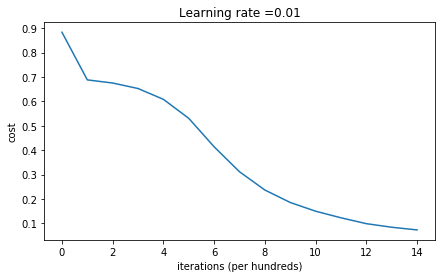

In [12]:
parameters = model(train_X, train_Y, initialization = "he")